<a href="https://colab.research.google.com/github/cstorm125/align_use/blob/master/sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Universal Sentence Encoder for Sentence Alignment

In [0]:
# #get europarl
# !wget https://www.dropbox.com/s/nr5h3xuqhlvj94m/europarl-v7.fr-en.en
# !wget https://www.dropbox.com/s/z730widwr5kw0zm/europarl-v7.fr-en.fr

In [0]:
# #get bucc2018
# !wget https://comparable.limsi.fr/bucc2018/bucc2018-fr-en.sample-gold.tar.bz2; tar -xf bucc2018-fr-en.sample-gold.tar.bz2; cd bucc2018/fr-en; mv * ../..

In [0]:
# #install dependencies
# !pip install tensorflow_text

In [139]:
!ls

 bucc2018				 europarl-v7.fr-en.fr
 bucc2018-fr-en.sample-gold.tar.bz2	 fr-en.sample.en
 bucc2018-fr-en.sample-gold.tar.bz2.1	 fr-en.sample.fr
 bucc2018-fr-en.sample-gold.tar.bz2.2	 fr-en.sample.gold
'download-sample-2018.cgi?langs=fr-en'	 sample_data
 europarl-v7.fr-en.en


In [0]:
import pandas as pd
import numpy as np
import tqdm
import tensorflow_hub as hub
import tensorflow_text
import tensorflow as tf #tensorflow 2.1.0

_model = hub.load('https://tfhub.dev/google/universal-sentence-encoder-multilingual/3')

class LSHasher:
    def __init__(self,hash_size = 10, input_dim = 512):
        self.hash_size = hash_size
        self.input_dim = input_dim
        self.projections = tf.random.normal((self.input_dim, self.hash_size))
    def get_hash(self,inp):
        res = inp@self.projections
        res = tf.cast(res > 0,tf.int32).numpy().astype(str)
        res = [''.join(i) for i in res]
        return res

def get_alignment(all_emb,input_idx):
    ref_idx = tf.constant(input_idx)[:,None]
    sub_emb = tf.gather_nd(params=all_emb, indices=ref_idx)
    x_ = tf.nn.l2_normalize(sub_emb,axis=1)
    res = x_@tf.transpose(x_)
    res = tf.linalg.set_diag(res, tf.constant(-2, dtype=float, shape=len(input_idx)))
    max_idx = tf.argmax(res,0).numpy()
    max_values = tf.reduce_max(res,0).numpy()
    max_input_idx = [input_idx[i] for i in max_idx]
    return max_input_idx, max_values

def get_alignment2(emb1,emb2):
    emb1_ = tf.nn.l2_normalize(emb1,axis=1)
    emb2_ = tf.nn.l2_normalize(emb2,axis=1)
    res = emb1_@tf.transpose(emb2_)
    max_idx = tf.argmax(res,1).numpy()
    max_values = tf.reduce_max(res,1).numpy()
    return max_idx, max_values

## Small Baseline with `europarl fr-en`

In [0]:
#read files
with open('europarl-v7.fr-en.fr','r') as f: fr = f.readlines()
with open('europarl-v7.fr-en.en','r') as f: en = f.readlines()
len(fr), len(en)

(2007723, 2007723)

In [0]:
#create dataframe
df = pd.DataFrame({'fr':[i[:-1] for i in fr],'en':[i[:-1] for i in en]})
#deduplicate based on fr
df['rnk'] = df.groupby('fr').cumcount()
df = df[df.rnk==0].drop('rnk',1).reset_index(drop=True)
df.tail()

,fr,en
1954617,Je donne la parole à M. Manders pour une motio...,Mr Manders has the floor for a procedural motion.
1954618,"Monsieur le Président, je voudrais profiter de...","Mr President, I would like to take this opport..."
1954619,"Mesdames et Messieurs les Députés, avant votre...","Ladies and gentlemen, before you leave me alon..."
1954620,"Je me permettrai même, bien qu'ils soient abse...","I would also like, although they are absent, t..."
1954621,Je ne rouvrirai pas le débat sur le millénaire...,I am not going to re-open the 'Millennium or n...


In [0]:
#randomize a subset of 1000 deduplicated sentences
rand_idx = np.random.choice(df.index, size=1000)

#get use
%time fr_emb = _model(df['fr'][rand_idx])
%time en_emb = _model(df['en'][rand_idx])
all_emb = tf.concat([fr_emb,en_emb],0)
all_emb.shape

CPU times: user 155 ms, sys: 2.88 ms, total: 158 ms
Wall time: 140 ms
CPU times: user 136 ms, sys: 2.9 ms, total: 139 ms
Wall time: 115 ms


TensorShape([2000, 512])

In [0]:
#test with first 1000 rows of deduped fr-en europarl
input_idx = [i for i in range(2000)]
max_input_idx, max_values = get_alignment(all_emb,input_idx)
res_df = pd.DataFrame({'src_idx':input_idx, 'targ_idx':max_input_idx,'score':max_values})
res_df

,src_idx,targ_idx,score
0,0,1000,0.720966
1,1,1001,0.724499
2,2,1002,0.712397
3,3,1003,0.770342
4,4,1004,0.749140
...,...,...,...
1995,1995,995,0.845170
1996,1996,996,0.860101
1997,1997,997,0.875563
1998,1998,998,0.831155


In [0]:
#fr to en
(res_df.iloc[:1000,:].src_idx==res_df.iloc[:1000,:].targ_idx-1000).mean()

0.981

In [0]:
#en to fr
(res_df.iloc[1000:,:].src_idx==res_df.iloc[1000:,:].targ_idx+1000).mean()

0.982

## Larger Baseline with `bucc2018 fr-en`

In [148]:
!ls

 bucc2018				 europarl-v7.fr-en.fr
 bucc2018-fr-en.sample-gold.tar.bz2	 fr-en.sample.en
 bucc2018-fr-en.sample-gold.tar.bz2.1	 fr-en.sample.fr
 bucc2018-fr-en.sample-gold.tar.bz2.2	 fr-en.sample.gold
'download-sample-2018.cgi?langs=fr-en'	 sample_data
 europarl-v7.fr-en.en


In [152]:
fr = pd.read_csv('fr-en.sample.fr',sep='\t',header=None)
en = pd.read_csv('fr-en.sample.en',sep='\t',header=None)
for i in [fr,en]: i.columns = ['id','text']
gold = pd.read_csv('fr-en.sample.gold',sep='\t',header=None)
gold.columns=['fr_id','en_id']
fr.shape,en.shape,gold.shape

((21316, 2), (37675, 2), (929, 2))

In [154]:
fr_embs = []
en_embs = []
bs = 10000
for i in range(fr.shape[0]//bs+1):
  fr_embs.append(_model(fr.iloc[bs*i:bs*(i+1),1]))
for i in range(en.shape[0]//bs+1):
  en_embs.append(_model(en.iloc[bs*i:bs*(i+1),1]))
fr_emb = tf.concat(fr_embs,0)
en_emb = tf.concat(en_embs,0)
fr_emb.shape, en_emb.shape

(TensorShape([21316, 512]), TensorShape([37675, 512]))

In [156]:
get_alignment2(fr_emb[:10000,:],fr_emb[:10000,:])

(array([   0,    1,    2, ..., 9997, 9998, 9999]),
 array([1.        , 1.        , 1.        , ..., 0.99999994, 0.99999976,
        0.9999998 ], dtype=float32))

In [184]:
reses = []
for i in range(fr_emb.shape[0]//bs+1):
  src_id = fr.iloc[bs*i:bs*(i+1),0]
  for j in range(en_emb.shape[0]//bs+1):
    dest_idx, score = get_alignment2(fr_emb[bs*i:bs*(i+1),:],en_emb[bs*j:bs*(j+1),:])
    dest_id = en.iloc[dest_idx,0]
    reses.append(pd.DataFrame({'src_id':list(src_id),'dest_id': list(dest_id),'score':score}))
res_df = pd.concat(reses,0).reset_index(drop=True)
res_df['rnk'] = res_df.sort_values('score',ascending=False).groupby('src_id').cumcount()
res_df = res_df[res_df.rnk==0].drop('rnk',1)
res_df.shape

(21316, 3)

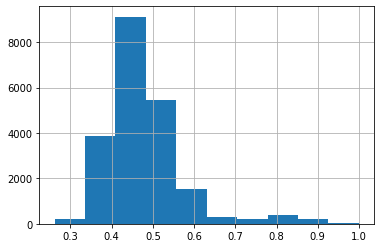

In [191]:
#distribution of similarity score
res_df.score.hist()

In [200]:
#predict match only when similarity is above threshold
threses = [i/100 for i in range(5,100,5)]
for thres in threses:
  res_joined = res_df[res_df.score>thres].merge(gold,how='left',left_on='src_id',right_on='fr_id')
  precision = (res_joined.dest_id==res_joined.en_id).sum() / res_joined.shape[0]
  recall = (res_joined.dest_id==res_joined.en_id).sum() / gold.shape[0]
  print(f'''
  threshold: {thres}
  accuracy: {(res_joined.dest_id==res_joined.en_id).mean()}
  f1: {2*((precision*recall)/(precision+recall))}
  precision: {precision}
  recall: {recall}
  ''')


  threshold: 0.05
  accuracy: 0.013792456370801277
  f1: 0.026432906271072153
  precision: 0.013792456370801277
  recall: 0.31646932185145316
  

  threshold: 0.1
  accuracy: 0.013792456370801277
  f1: 0.026432906271072153
  precision: 0.013792456370801277
  recall: 0.31646932185145316
  

  threshold: 0.15
  accuracy: 0.013792456370801277
  f1: 0.026432906271072153
  precision: 0.013792456370801277
  recall: 0.31646932185145316
  

  threshold: 0.2
  accuracy: 0.013792456370801277
  f1: 0.026432906271072153
  precision: 0.013792456370801277
  recall: 0.31646932185145316
  

  threshold: 0.25
  accuracy: 0.013792456370801277
  f1: 0.026432906271072153
  precision: 0.013792456370801277
  recall: 0.31646932185145316
  

  threshold: 0.3
  accuracy: 0.013805409466566491
  f1: 0.02645669291338583
  precision: 0.013805409466566491
  recall: 0.31646932185145316
  

  threshold: 0.35
  accuracy: 0.014097338767681612
  f1: 0.02699228791773779
  precision: 0.014097338767681612
  recall: 0.3164

In [201]:
  #best thres around 0.7
  thres=0.7
  res_joined = res_df[res_df.score>thres].merge(gold,how='left',left_on='src_id',right_on='fr_id')
  precision = (res_joined.dest_id==res_joined.en_id).sum() / res_joined.shape[0]
  recall = (res_joined.dest_id==res_joined.en_id).sum() / gold.shape[0]
  print(f'''
  threshold: {thres}
  accuracy: {(res_joined.dest_id==res_joined.en_id).mean()}
  f1: {2*((precision*recall)/(precision+recall))}
  precision: {precision}
  recall: {recall}
  ''')


threshold: 0.7
accuracy: 0.30357142857142855
f1: 0.28829847371396267
precision: 0.30357142857142855
recall: 0.2744886975242196

